In [1]:
!pip install caer canaro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.5/809.5 kB 21.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 78.7 MB/s eta 0:00:00:00:0100:01


In [2]:
import caer
import canaro
import numpy as np
import cv2 as cv
import gc

In [3]:
img_size=(128,128)
channels=1
char_path=r'/kaggle/input/cat-and-dog/training_set/training_set'

In [4]:
#Create the traning data
classes=['cats','dogs']
images = caer.preprocess_from_dir(char_path,classes,channels=channels,IMG_SIZE=img_size,isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] At 3000 files
[INFO] At 4000 files
[INFO] 4000 files found in 8.69159746170044s
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] At 3000 files
[INFO] At 4000 files
[INFO] 4005 files found in 10.279913663864136s
----------------------------------------------
[INFO] 8005 files preprocessed! Took 2m 15s


In [5]:
features,labels=caer.sep_train(images,IMG_SIZE=img_size)

In [6]:
#normalizing
features=caer.normalize(features)

# Convert labels: change 0 to -1 and 1 to 1
labels = np.where(labels == 0, -1, labels)  # Convert all 0 labels to -1

# Flatten the images after loading them
feature = np.array([img.flatten() for img in features])

print(feature)
print(labels)

[[0.36078432 0.34509805 0.3882353  ... 0.627451   0.6666667  0.6431373 ]
 [0.34117648 0.2627451  0.21960784 ... 0.07450981 0.05882353 0.0627451 ]
 [0.2        0.22352941 0.2627451  ... 0.35686275 0.36078432 0.34901962]
 ...
 [0.9019608  0.8745098  0.8862745  ... 0.6627451  0.5294118  0.5921569 ]
 [0.30980393 0.33333334 0.11372549 ... 0.50980395 0.5764706  0.5686275 ]
 [0.60784316 0.65882355 0.68235296 ... 0.4745098  0.4627451  0.53333336]]
[ 1  1 -1 ...  1 -1  1]


In [7]:
!pip install cvxopt

In [8]:
import pandas as pd
import math as math
from cvxopt import solvers,matrix
import matplotlib.pyplot as plt

In [9]:
P=np.zeros((500,500))
Q=-np.ones((500,1))
Q=Q.astype(float)
G=-np.eye(500)
G=G.astype(float)
A=np.array(labels[:500],dtype=float).reshape(1,-1)
A=A.astype(float)
h=np.zeros((500,1))
h=h.astype(float)
b=np.zeros(1)
b=b.astype(float)

row=0.001

for i in range(500):
    P[i]=np.array([math.exp(-row*(np.dot((feature[i]-feature[j]),(feature[i]-feature[j]).T)))*labels[i]*labels[j] for j in range(500)])

In [10]:
P=matrix(P)
Q=matrix(Q)
G=matrix(G)
A=matrix(A)
h=matrix(h)
b=matrix(b)

sol=solvers.qp(P,Q,G,h,A,b)
alpha=np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -2.5109e+02 -7.0267e+02  5e+02  4e-15  2e+00
 1: -3.4906e+02 -4.7083e+02  1e+02  4e-15  8e-01
 2: -4.8232e+02 -5.6072e+02  8e+01  2e-14  3e-02
 3: -4.8400e+02 -4.8627e+02  2e+00  6e-14  7e-04
 4: -4.8401e+02 -4.8404e+02  3e-02  3e-14  8e-06
 5: -4.8401e+02 -4.8401e+02  5e-04  9e-15  9e-08
Optimal solution found.


In [11]:
#Calculate the bias term (z) using the support vectors
z_sum=0
count=0

for i in range(500):
    if abs(sol['x'][i])>1e-5: # Check if alpha is a support vector
        sum_term=0
        for j in range(500):
            # Compute the RBF kernal value for the support vector
            term=feature[i]-feature[j]
            term_2=np.dot(term,term.T)
            sum_term+=sol['x'][j]*labels[j]*math.exp(-term_2*row)

        #Calculate bias term for each support vector
        c=labels[i]-sum_term
        z_sum+=c
        count+=1

#Average bias over all support vectors
if count>0:
    z=z_sum/count
else:
    z=0 # This handles the edge case where no support vectors are found

print("Bias (z):",z)

Bias (z): 0.11913878053716341


Enter the rth example (example index):  400


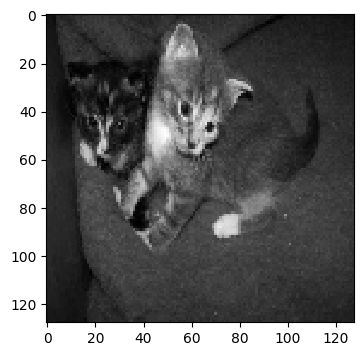

cat -0.9999659936002775 -1


Enter the rth example (example index):  20


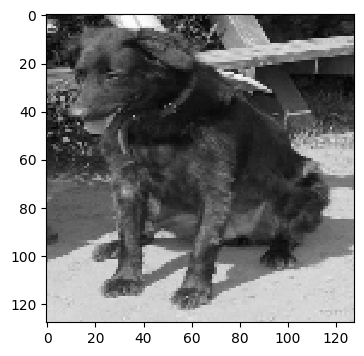

dog 1.000034297084868 1


Enter the rth example (example index):  36


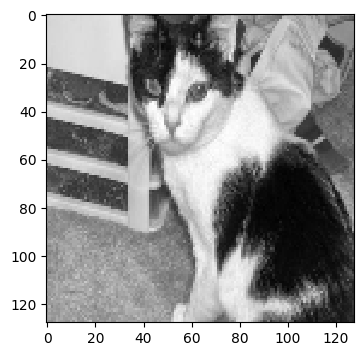

cat -0.9999657854336118 -1


Enter the rth example (example index):  66


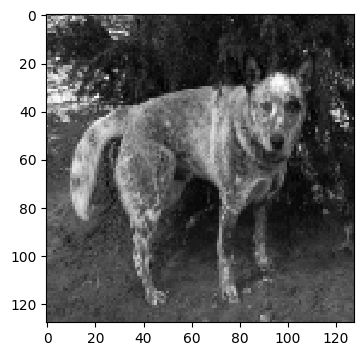

dog 1.000034480663428 1


Enter the rth example (example index):  27


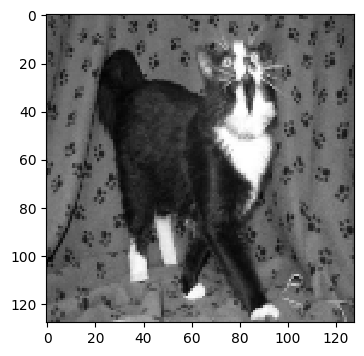

cat -0.9999658762090803 -1


KeyboardInterrupt: Interrupted by user

In [12]:
# Interactive testing loop to classify examples

while(True):

    r=int(input("Enter the rth example (example index): "))
    t=feature[r]
    
    # Display the test example as a 28x28 image(assuming MNIST dataset)
    plt.figure(figsize=(4,4))
    idx=r
    grid_data=feature[idx].reshape(128,128) # Reshape the feature vector into 28x28 image
    plt.imshow(grid_data,interpolation="none",cmap="gray")
    plt.show()

    # Predict the class for the test example using trained SVM model
    sum=0
    for i  in range(500):
        term=feature[i]-feature[r]
        term_2=np.dot(term,term.T)
        sum=sum+sol['x'][i]*labels[i]*math.exp(-term_2*row)

    # Decision rule: if sum + bias > 0,predict class 1; otherwise,class -1(ie 0)
    if(sum+z>0):
        print('dog',sum+z,labels[r])

    else:
        print('cat',sum+z,labels[r])